In [9]:
import pandas as pd
import backtrader as bt
import yfinance as yf
import matplotlib.pyplot as plt

In [10]:
# 导入数据
dat = yf.Ticker('AAPL')
dat_hist = dat.history(period='1Y')
dat_hist.index = pd.to_datetime(dat_hist.index).normalize()
dat_hist.drop(columns=['Dividends', 'Stock Splits'], inplace=True)
dat_hist.head()

,Open,High,Low,Close,Volume
Date,,,,,
2024-08-21 00:00:00-04:00,225.470651,226.923879,224.007459,225.351196,34765500
2024-08-22 00:00:00-04:00,226.734776,227.282232,222.862797,223.489883,43695300
2024-08-23 00:00:00-04:00,224.614643,227.162781,223.290802,225.789169,38677300
2024-08-26 00:00:00-04:00,225.709526,226.227122,222.852826,226.127579,30602200
2024-08-27 00:00:00-04:00,224.953053,227.789857,223.848195,226.973648,35934600


# 定义MACD策略
-  **卖出信号**:慢线穿过快线
-  **买入信号**:快线穿过慢线
-  **快线周期数**:选择14个交易日
-  **慢线周期**:选择近26个交易日
-  **信号周期**：选择9个交易日

In [11]:
class MACD_Strategy(bt.Strategy):
    # 定义策略的参数
    params = (('macd_fast', 14),
              ('macd_slow', 26),
              ('macd_signal', 9))
                 
    def __init__(self):
        # 记录收盘价，方便后续使用
        self.dataclose = self.datas[0].close
        # 用来跟踪未完成的订单
        self.order = None
        self.buyprice = None # 记录买入价格
        self.comm = None     # 记录佣金
        self.macd = bt.indicators.MACD(self.data,
                                       period_me1=self.p.macd_fast,
                                       period_me2=self.p.macd_slow,
                                       period_signal=self.p.macd_signal)
        self.macd_hist = self.macd.macd - self.macd.signal

    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            return
        # 如果订单是完成状态 (买入/卖出)
        if order.status in [order.Completed]:
            if order.isbuy():
                self.buyprice = order.executed.price
                self.comm = order.executed.comm
                print(f"买入执行 - 日期: {self.data.datetime.date()}, 价格: {order.executed.price:.2f}, 成本: {order.executed.value:.2f}, 佣金: {order.executed.comm:.2f}")
            elif order.issell():
                print(f"卖出执行 - 日期: {self.data.datetime.date()}, 价格: {order.executed.price:.2f}, 成本: {order.executed.value:.2f}, 佣金: {order.executed.comm:.2f}")
            self.bar_executed = len(self) # 记录订单执行时的 bar 数量
        # 如果订单是取消、保证金不足、拒绝等状态
        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            print(f"订单状态: {order.Status[order.status]} - 日期: {self.data.datetime.date()}")
        self.order = None

    def notify_trade(self, trade):
        # 交易完成（平仓）时调用
        if not trade.isclosed:
            return
        print(f"交易完成 - 毛利润: {trade.pnl:.2f}, 净利润: {trade.pnlcomm:.2f}")
        
    def next(self):        
        current_close = self.dataclose[0]
        macd_line = self.macd.macd[0]
        last_macd_line = self.macd.macd[-1]
        macd_signal_line = self.macd.signal[0]
        last_macd_signal_line = self.macd.signal[-1]

        # ====买入信号====
        if not self.position:
            if macd_line > macd_signal_line and last_macd_line < last_macd_signal_line:
                self.order = self.buy(size=10) # 假设买入10个单位
                print(f"发出买入信号 - 日期: {self.data.datetime.date()}, "
                      f"收盘: {current_close:.2f}, MACD: {macd_line:.2f}, 信号: {macd_signal_line:.2f}")
        # ====卖出信号====
        else:
            if macd_line < macd_signal_line and last_macd_line > last_macd_signal_line:
                self.order = self.close() # 平仓所有持仓
                print(f"发出卖出信号 - 日期: {self.data.datetime.date()}, "
                      f"收盘: {current_close:.2f}, MACD: {macd_line:.2f}, 信号: {macd_signal_line:.2f}")
                
        # ====特殊情况====
        max_period = max(self.p.macd_slow, self.p.macd_signal)                
        if len(self) < max_period:
            return
        if self.order:
            return

# Cerebro实例化  
- **indicators**:收益率、夏普比率、胜率比、盈亏比、最大回撤

初始资金: 100000.00
发出买入信号 - 日期: 2024-10-14, 收盘: 230.23, MACD: 1.00, 信号: 0.85
买入执行 - 日期: 2024-10-15, 价格: 232.53, 成本: 2325.28, 佣金: 1.40
发出卖出信号 - 日期: 2024-10-25, 收盘: 230.34, MACD: 1.64, 信号: 1.66
卖出执行 - 日期: 2024-10-28, 价格: 232.24, 成本: 2325.28, 佣金: 1.39
交易完成 - 毛利润: -2.89, 净利润: -5.68
发出买入信号 - 日期: 2024-11-19, 收盘: 227.47, MACD: -0.37, 信号: -0.44
买入执行 - 日期: 2024-11-20, 价格: 227.25, 成本: 2272.53, 佣金: 1.36
发出卖出信号 - 日期: 2024-12-31, 收盘: 249.53, MACD: 4.37, 信号: 4.64
卖出执行 - 日期: 2025-01-02, 价格: 248.05, 成本: 2272.53, 佣金: 1.49
交易完成 - 毛利润: 207.96, 净利润: 205.11
发出买入信号 - 日期: 2025-01-29, 收盘: 238.51, MACD: -2.75, 信号: -2.77
买入执行 - 日期: 2025-01-30, 价格: 237.83, 成本: 2378.26, 佣金: 1.43
发出卖出信号 - 日期: 2025-03-04, 收盘: 235.35, MACD: 0.88, 信号: 1.16
卖出执行 - 日期: 2025-03-05, 价格: 234.85, 成本: 2378.26, 佣金: 1.41
交易完成 - 毛利润: -29.81, 净利润: -32.64
发出买入信号 - 日期: 2025-03-26, 收盘: 220.99, MACD: -3.99, 信号: -4.16
买入执行 - 日期: 2025-03-27, 价格: 220.85, 成本: 2208.49, 佣金: 1.33
发出卖出信号 - 日期: 2025-04-03, 收盘: 202.69, MACD: -3.44, 信号: -3.40
卖出执行 - 日期: 2025-04-

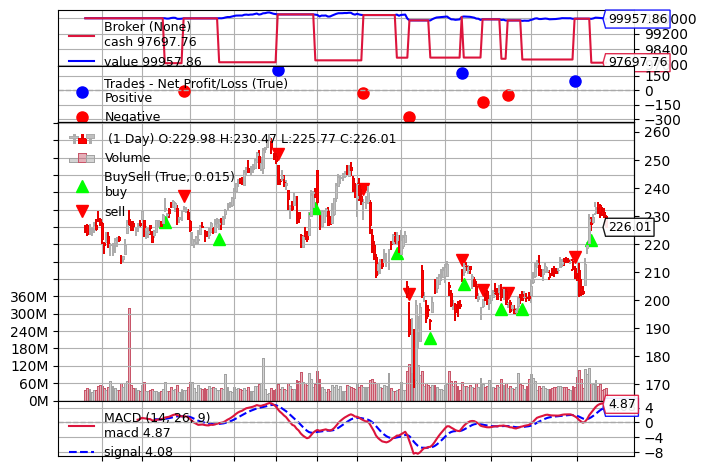

[[<Figure size 640x480 with 5 Axes>]]

In [12]:
# 创建实例
cerebro = bt.Cerebro()
cerebro.addanalyzer(bt.analyzers.TradeAnalyzer, _name='trade_analyzer')
cerebro.addanalyzer(bt.analyzers.Returns, _name='returns_analyzer', timeframe=bt.TimeFrame.Days)
cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name='sharp_analyzer', timeframe=bt.TimeFrame.Years)
cerebro.addanalyzer(bt.analyzers.DrawDown, _name='drwa_analyzer')

# 导入数据策略，初始化设置
data = bt.feeds.PandasData(
    dataname=dat_hist,
    open='Open',
    high='High',
    low='Low',
    close='Close',
    volume='Volume',
    timeframe=bt.TimeFrame.Days
)
cerebro.adddata(data)
cerebro.addstrategy(MACD_Strategy)
cerebro.broker.setcash(100000.0)
cerebro.broker.setcommission(commission=0.0006)

# 运行策略
print(f"初始资金: {cerebro.broker.getvalue():.2f}")
resuluts = cerebro.run()
thestrat = resuluts[0]
trade_analyzer = thestrat.analyzers.trade_analyzer.get_analysis()
return_analyzer = thestrat.analyzers.returns_analyzer.get_analysis()
sharp_analyzer = thestrat.analyzers.sharp_analyzer.get_analysis()
draw_analyzer = thestrat.analyzers.drwa_analyzer.get_analysis()
print(f"最终资金为：{cerebro.broker.getvalue():.2f}")
print(f"总收益率为：{return_analyzer.get('rtot', 0) * 100:.2f}%")
print(f"夏普比率为：{sharp_analyzer['sharperatio']:.4f}")

total_trades = trade_analyzer.total.closed
winning_trades = trade_analyzer.won.total
win_rate = (winning_trades / total_trades) * 100 if total_trades > 0 else 0
print(f"胜率比为：{winning_trades}/{total_trades}，{win_rate:.2f}%")

gross_profit = trade_analyzer.won.pnl.total
gross_loss = abs(trade_analyzer.lost.pnl.total)
profit_factor = gross_profit / gross_loss if gross_loss > 0 else float('inf')
print(f"盈亏比为：{profit_factor:.2f}")
print(f"最大回撤为：{draw_analyzer.max.drawdown:.2f}%")

%matplotlib inline
cerebro.plot(style='candlestick', iplot=False)